In [1]:
pip install torch torchvision scikit-learn

**Part 1**

---


Data Preparation: Use PyTorch to load the CIFAR-10 dataset, perform a
stratified random split in the ratio of 0.8:0.2 for the training and validation datasets.
Here, the 15,000 images from the training dataset are split into train-val via 0.8:0.2
split, and 3,000 images (1,000 per class) are retained as the testing data from the
original test dataset of CIFAR-10. Create a custom Dataset class for the data and
create data loaders for all the dataset splits - train, val, and test.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np

# Define the classes we'll use
SELECTED_CLASSES = ['dog', 'cat', 'truck']

class CustomCIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Custom dataset for selected classes from CIFAR-10

        Args:
            images (numpy.ndarray): Array of images
            labels (numpy.ndarray): Array of corresponding labels
            transform (callable, optional): Optional transform to be applied on images
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # Apply transforms if specified
        if self.transform:
            img = self.transform(img)

        return img, label

def prepare_cifar10_dataset():
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load full CIFAR-10 dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

    # CIFAR-10 class names
    classes = ['plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

    # Get indices for selected classes
    selected_class_indices = [classes.index(cls) for cls in SELECTED_CLASSES]

    # Filter training data for selected classes
    train_mask = np.isin(trainset.targets, selected_class_indices)
    train_images = trainset.data[train_mask]
    train_labels = np.array(trainset.targets)[train_mask]
    train_labels = np.array([selected_class_indices.index(label) for label in train_labels])

    # Filter test data for selected classes
    test_mask = np.isin(testset.targets, selected_class_indices)
    test_images = testset.data[test_mask]
    test_labels = np.array(testset.targets)[test_mask]
    test_labels = np.array([selected_class_indices.index(label) for label in test_labels])

    # Create custom datasets with transforms
    train_dataset = CustomCIFAR10Dataset(train_images, train_labels, transform=transform)
    test_dataset = CustomCIFAR10Dataset(test_images, test_labels, transform=transform)

    # Stratified split for train and validation
    from sklearn.model_selection import train_test_split

    # Split indices maintaining class distribution
    train_indices, val_indices = train_test_split(
        np.arange(len(train_dataset)),
        test_size=0.2,
        stratify=train_dataset.labels,
        random_state=42
    )

    # Create train and validation subsets
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(train_dataset, val_indices)

    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, val_loader, test_loader, len(SELECTED_CLASSES)

# Example usage
if __name__ == '__main__':
    train_loader, val_loader, test_loader, num_classes = prepare_cifar10_dataset()

    # Print some information about the datasets
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    print(f"Number of test batches: {len(test_loader)}")
    print(f"Number of classes: {num_classes}")

100%|██████████| 170M/170M [00:04<00:00, 37.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of training batches: 188
Number of validation batches: 47
Number of test batches: 47
Number of classes: 3


**Part 2**


---

Visualization: Load the dataset and visualize 5 images of each class
from both the training and validation datasets.

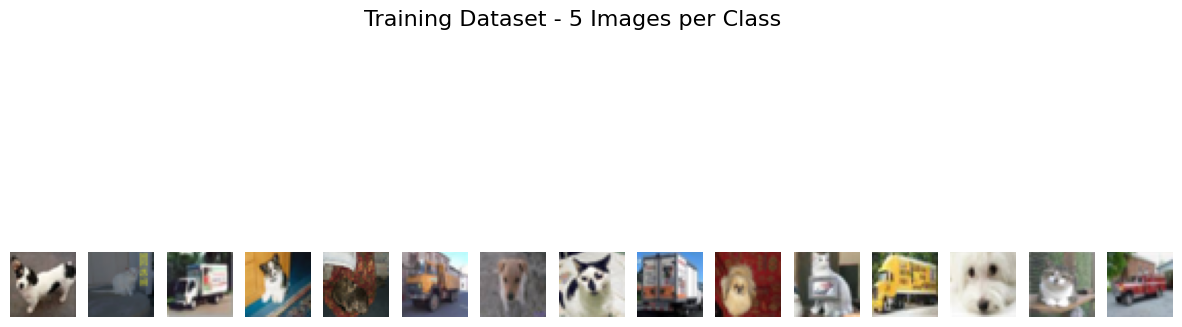

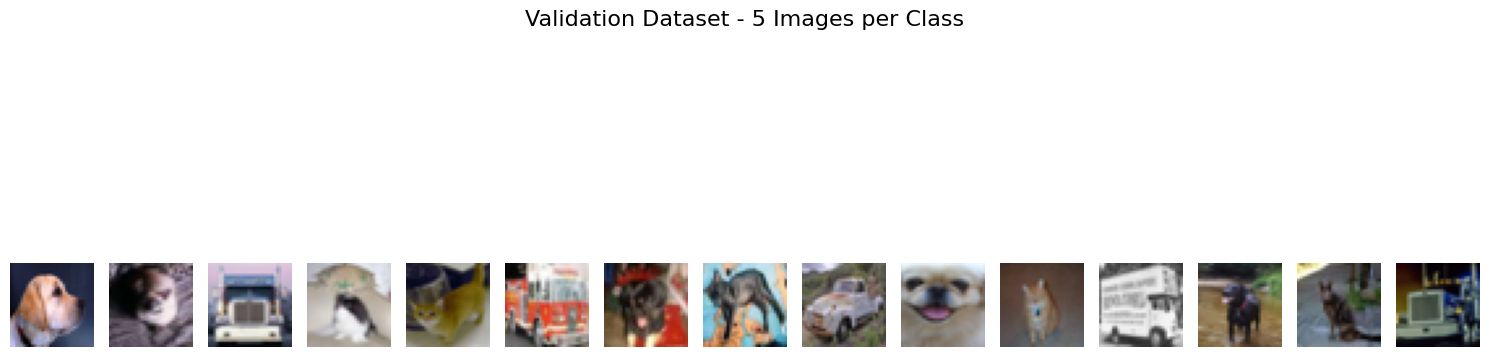

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_dataset(train_loader, val_loader, classes):
    def imshow(img):
        img = img / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')

    # Visualization for Training Dataset
    plt.figure(figsize=(15, 10))
    plt.suptitle('Training Dataset - 5 Images per Class', fontsize=16)

    # Track images per class for training
    train_class_counts = {cls: 0 for cls in classes}

    for images, labels in train_loader:
        for i in range(len(images)):
            cls = classes[labels[i]]
            if train_class_counts[cls] < 5:
                plt.subplot(2, 15, train_class_counts[cls] * 3 + classes.index(cls) + 1)
                imshow(images[i])
                train_class_counts[cls] += 1

        # Break if we've found 5 images for each class
        if all(count == 5 for count in train_class_counts.values()):
            break

    # Visualization for Validation Dataset
    plt.figure(figsize=(15, 10))
    plt.suptitle('Validation Dataset - 5 Images per Class', fontsize=16)

    # Track images per class for validation
    val_class_counts = {cls: 0 for cls in classes}

    for images, labels in val_loader:
        for i in range(len(images)):
            cls = classes[labels[i]]
            if val_class_counts[cls] < 5:
                plt.subplot(2, 15, val_class_counts[cls] * 3 + classes.index(cls) + 1)
                imshow(images[i])
                val_class_counts[cls] += 1

        # Break if we've found 5 images for each class
        if all(count == 5 for count in val_class_counts.values()):
            break

    plt.tight_layout()
    plt.show()

# Assuming you have train_loader, val_loader, and classes from previous implementation
visualize_dataset(train_loader, val_loader, SELECTED_CLASSES)

**Part 3**

---

CNN Implementation

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CIFAR10CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CIFAR10CNN, self).__init__()

        # First Convolutional Layer
        # Input: 3 color channels, Output: 16 channels
        # Kernel size: 5x5, Padding: 1, Stride: 1
        self.conv1 = nn.Conv2d(
            in_channels=3,      # RGB input
            out_channels=16,    # 16 channels as specified
            kernel_size=5,      # 5x5 kernel
            stride=1,           # Stride of 1
            padding=1           # Padding of 1
        )

        # First Max Pooling Layer
        # Kernel size: 3x3, Stride: 2
        self.pool1 = nn.MaxPool2d(
            kernel_size=3,      # 3x3 kernel
            stride=2            # Stride of 2
        )

        # Second Convolutional Layer
        # Input: 16 channels, Output: 32 channels
        # Kernel size: 3x3, Padding: 0, Stride: 1
        self.conv2 = nn.Conv2d(
            in_channels=16,     # Input from previous layer
            out_channels=32,    # 32 channels as specified
            kernel_size=3,      # 3x3 kernel
            stride=1,           # Stride of 1
            padding=0           # No padding
        )

        # Second Max Pooling Layer
        # Kernel size: 3x3, Stride: 3
        self.pool2 = nn.MaxPool2d(
            kernel_size=3,      # 3x3 kernel
            stride=3            # Stride of 3
        )

        # First Fully Connected Layer
        # Calculate the input features dynamically
        self.fc1 = nn.Linear(
            in_features=self._get_conv_output_features(),  # Dynamic calculation
            out_features=16     # 16 neurons as specified
        )

        # Classification Head (Final Layer)
        self.fc2 = nn.Linear(
            in_features=16,     # Input from previous layer
            out_features=num_classes  # Number of classes to classify
        )

    def _get_conv_output_features(self):
        # Create a dummy input to calculate the flattened feature size
        with torch.no_grad():
            x = torch.zeros(1, 3, 32, 32)  # Dummy input matching CIFAR-10 image size
            x = self.conv1(x)
            x = self.pool1(x)
            x = self.conv2(x)
            x = self.pool2(x)
            return int(torch.prod(torch.tensor(x.shape[1:])))

    def forward(self, x):
        # First Convolutional Layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        # Second Convolutional Layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # First Fully Connected Layer
        x = self.fc1(x)
        x = F.relu(x)

        # Classification Head
        x = self.fc2(x)

        return x

# Example usage
if __name__ == '__main__':
    # Create an instance of the model
    model = CIFAR10CNN(num_classes=3)

    # Print model summary
    print(model)

    # Test with a dummy input
    dummy_input = torch.randn(1, 3, 32, 32)
    output = model(dummy_input)
    print("\nInput shape:", dummy_input.shape)
    print("Output shape:", output.shape)

CIFAR10CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)

Input shape: torch.Size([1, 3, 32, 32])
Output shape: torch.Size([1, 3])


**Part 4**

---

Training the model: Train the model using the cross-entropy loss func-
tion with Adam optimizer for 15 epochs.

Epoch [1/15]
Train Loss: 0.7891, Train Accuracy: 60.25%
Val Loss: 0.6521, Val Accuracy: 67.27%
--------------------------------------------------
Epoch [2/15]
Train Loss: 0.6276, Train Accuracy: 69.21%
Val Loss: 0.5897, Val Accuracy: 70.23%
--------------------------------------------------
Epoch [3/15]
Train Loss: 0.5840, Train Accuracy: 71.30%
Val Loss: 0.5845, Val Accuracy: 71.47%
--------------------------------------------------
Epoch [4/15]
Train Loss: 0.5510, Train Accuracy: 73.26%
Val Loss: 0.5886, Val Accuracy: 71.77%
--------------------------------------------------
Epoch [5/15]
Train Loss: 0.5243, Train Accuracy: 74.66%
Val Loss: 0.5516, Val Accuracy: 70.33%
--------------------------------------------------
Epoch [6/15]
Train Loss: 0.5052, Train Accuracy: 76.34%
Val Loss: 0.5729, Val Accuracy: 71.90%
--------------------------------------------------
Epoch [7/15]
Train Loss: 0.4886, Train Accuracy: 77.15%
Val Loss: 0.4903, Val Accuracy: 76.80%
-----------------------------

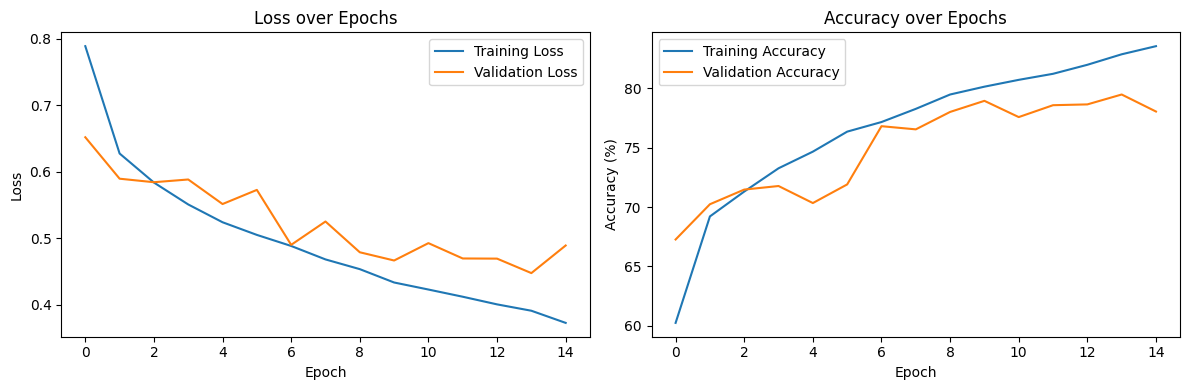

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

def train_model(model, train_loader, val_loader, num_epochs=15, learning_rate=0.001):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move model to device
    model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Tracking metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            # Move data to device
            data, targets = data.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(data)

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += targets.size(0)
            total_train_correct += (predicted == targets).sum().item()
            total_train_loss += loss.item()

        # Validation phase
        model.eval()
        total_val_loss = 0.0
        total_val_correct = 0
        total_val_samples = 0

        with torch.no_grad():
            for data, targets in val_loader:
                # Move data to device
                data, targets = data.to(device), targets.to(device)

                # Forward pass
                outputs = model(data)

                # Compute loss
                loss = criterion(outputs, targets)

                # Compute validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_val_samples += targets.size(0)
                total_val_correct += (predicted == targets).sum().item()
                total_val_loss += loss.item()

        # Compute epoch metrics
        train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100 * total_train_correct / total_train_samples
        val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * total_val_correct / total_val_samples

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print epoch summary
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
        print('-' * 50)

    # Create models directory if it doesn't exist
    os.makedirs('models', exist_ok=True)

    # Save the trained model
    model_path = f'models/cifar10_cnn_model_final.pth'
    torch.save(model.state_dict(), model_path)
    print(f'\nModel saved to {model_path}')

    # Plot training and validation metrics
    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

# Assuming you have train_loader, val_loader, and the model defined earlier
# Example usage would look like:
# trained_model, training_history = train_model(model, train_loader, val_loader)
trained_model, training_history = train_model(model, train_loader, val_loader)

**Part 5**


---


Testing: Observe the training and validation plots for loss and accuracy
and comment on your understanding of the results.

Testing on Training Dataset:
Test Accuracy: 82.47%
Weighted F1 Score: 0.8216


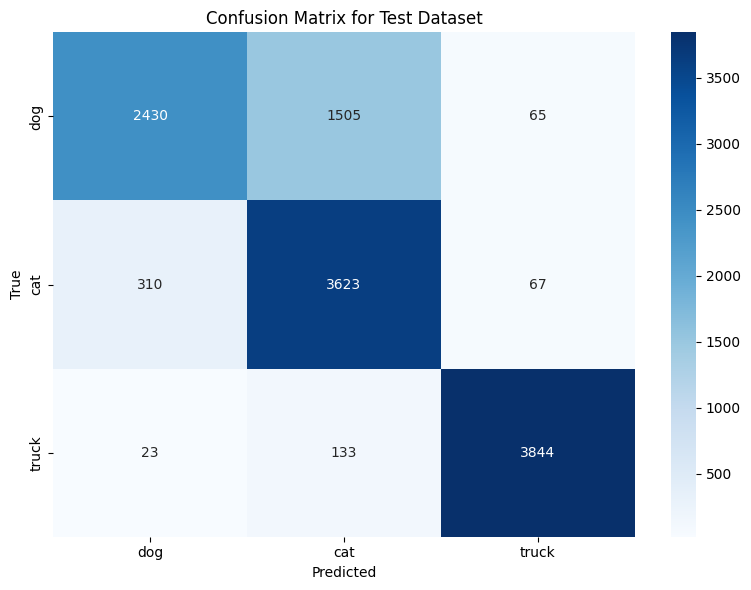


Detailed Classification Report:
              precision    recall  f1-score   support

         dog       0.88      0.61      0.72      4000
         cat       0.69      0.91      0.78      4000
       truck       0.97      0.96      0.96      4000

    accuracy                           0.82     12000
   macro avg       0.84      0.82      0.82     12000
weighted avg       0.84      0.82      0.82     12000



Testing on Validation Dataset:
Test Accuracy: 78.03%
Weighted F1 Score: 0.7776


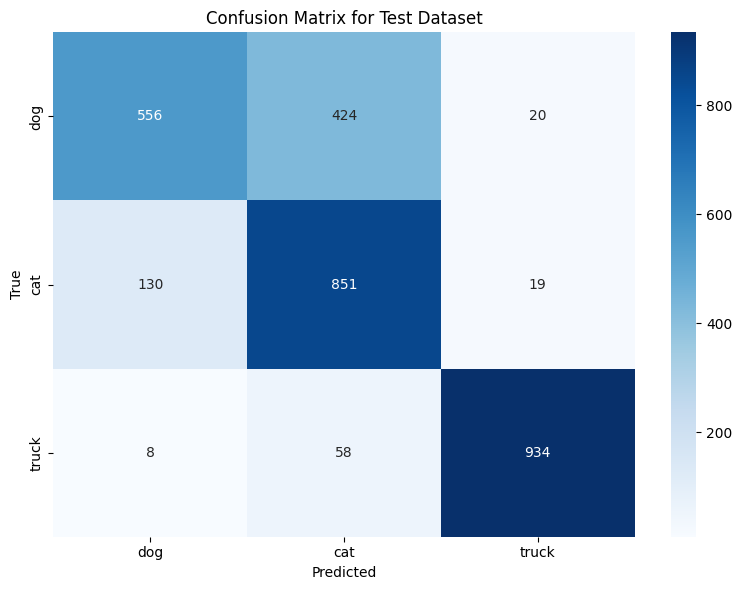


Detailed Classification Report:
              precision    recall  f1-score   support

         dog       0.80      0.56      0.66      1000
         cat       0.64      0.85      0.73      1000
       truck       0.96      0.93      0.95      1000

    accuracy                           0.78      3000
   macro avg       0.80      0.78      0.78      3000
weighted avg       0.80      0.78      0.78      3000



Testing on Test Dataset:
Test Accuracy: 78.67%
Weighted F1 Score: 0.7835


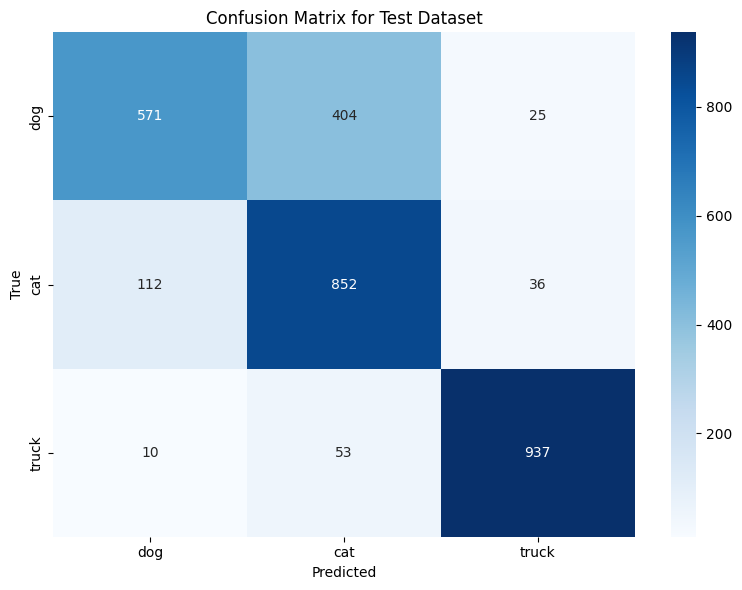


Detailed Classification Report:
              precision    recall  f1-score   support

         dog       0.82      0.57      0.67      1000
         cat       0.65      0.85      0.74      1000
       truck       0.94      0.94      0.94      1000

    accuracy                           0.79      3000
   macro avg       0.80      0.79      0.78      3000
weighted avg       0.80      0.79      0.78      3000



In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score

def test_model(model, test_loader, classes):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move model to device and set to evaluation mode
    model.to(device)
    model.eval()

    # Lists to store predictions and true labels
    all_preds = []
    all_labels = []

    # Disable gradient calculation during testing
    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in test_loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)

            # Update totals
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and labels for further analysis
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = 100 * correct / total

    # Calculate F1 Score
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Print test results
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Weighted F1 Score: {f1:.4f}')

    # Generate and plot confusion matrix
    def plot_confusion_matrix(labels, preds, title):
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes,
                    yticklabels=classes)
        plt.title(title)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, 'Confusion Matrix for Test Dataset')

    # Print detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': all_preds,
        'true_labels': all_labels
    }

# Example usage
def test_all_datasets(model, train_loader, val_loader, test_loader, classes):
    print("Testing on Training Dataset:")
    train_results = test_model(model, train_loader, classes)

    print("\n" + "="*50 + "\n")

    print("Testing on Validation Dataset:")
    val_results = test_model(model, val_loader, classes)

    print("\n" + "="*50 + "\n")

    print("Testing on Test Dataset:")
    test_results = test_model(model, test_loader, classes)

    return train_results, val_results, test_results

# Assuming you have:
# - model (trained CIFAR10CNN)
# - train_loader, val_loader, test_loader
# - classes (list of class names)
# test_results = test_all_datasets(model, train_loader, val_loader, test_loader, SELECTED_CLASSES)
test_results = test_all_datasets(model, train_loader, val_loader, test_loader, SELECTED_CLASSES)

**Part 6**

---
Training an MLP:


CIFAR10MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

Input shape: torch.Size([1, 3, 32, 32])
Output shape: torch.Size([1, 3])
Epoch [1/15]
Train Loss: 0.7772, Train Accuracy: 61.62%
Val Loss: 0.7341, Val Accuracy: 64.17%
--------------------------------------------------
Epoch [2/15]
Train Loss: 0.6833, Train Accuracy: 67.42%
Val Loss: 0.6978, Val Accuracy: 65.93%
--------------------------------------------------
Epoch [3/15]
Train Loss: 0.6458, Train Accuracy: 69.54%
Val Loss: 0.7001, Val Accuracy: 66.73%
--------------------------------------------------
Epoch [4/15]
Train Loss: 0.6046, Train Accuracy: 71.18%
Val Loss: 0.6872, Val Accuracy: 67.63%
--------------------------------------------------
Epoch [5/15]
Train Loss: 0.5802, Train Accuracy: 72.83%
Val Loss: 0.7183, Val Accuracy: 66.77%
-------------------------------------------------

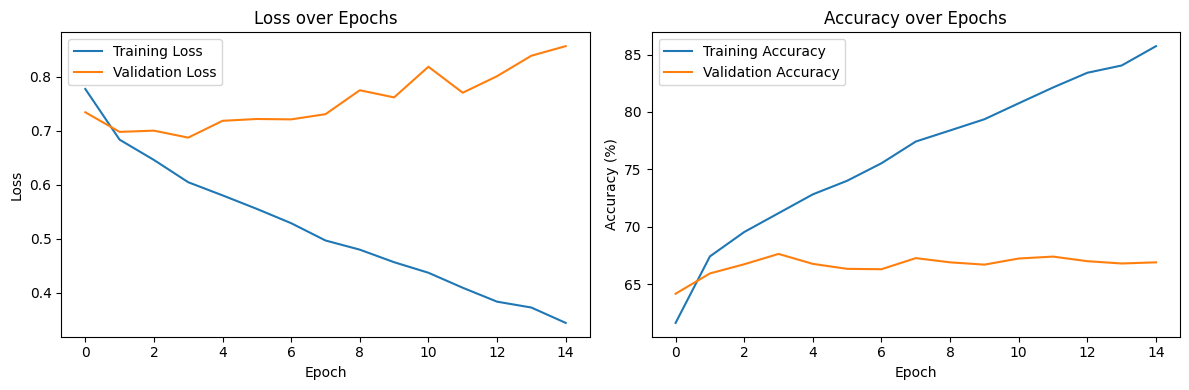

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

class CIFAR10MLP(nn.Module):
    def __init__(self, num_classes=3):
        super(CIFAR10MLP, self).__init__()

        # Flatten layer (to be used before the first FC layer)
        self.flatten = nn.Flatten()

        # First Fully Connected Layer
        self.fc1 = nn.Linear(
            in_features=3 * 32 * 32,  # Flattened input from 32x32x3 image
            out_features=64            # 64 neurons as specified
        )

        # ReLU Activation
        self.relu = nn.ReLU()

        # Classification Head (Final Layer)
        self.fc2 = nn.Linear(
            in_features=64,            # Input from previous layer
            out_features=num_classes   # Number of classes to classify
        )

    def forward(self, x):
        # Flatten the input
        x = self.flatten(x)

        # First Fully Connected Layer with ReLU
        x = self.fc1(x)
        x = self.relu(x)

        # Classification Head
        x = self.fc2(x)

        return x

def train_mlp_model(model, train_loader, val_loader, num_epochs=15, learning_rate=0.001):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move model to device
    model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Tracking metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            # Move data to device
            data, targets = data.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(data)

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += targets.size(0)
            total_train_correct += (predicted == targets).sum().item()
            total_train_loss += loss.item()

        # Validation phase
        model.eval()
        total_val_loss = 0.0
        total_val_correct = 0
        total_val_samples = 0

        with torch.no_grad():
            for data, targets in val_loader:
                # Move data to device
                data, targets = data.to(device), targets.to(device)

                # Forward pass
                outputs = model(data)

                # Compute loss
                loss = criterion(outputs, targets)

                # Compute validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_val_samples += targets.size(0)
                total_val_correct += (predicted == targets).sum().item()
                total_val_loss += loss.item()

        # Compute epoch metrics
        train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100 * total_train_correct / total_train_samples
        val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * total_val_correct / total_val_samples

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print epoch summary
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
        print('-' * 50)

    # Create models directory if it doesn't exist
    os.makedirs('models', exist_ok=True)

    # Save the trained model
    model_path = f'models/cifar10_mlp_model_final.pth'
    torch.save(model.state_dict(), model_path)
    print(f'\nModel saved to {model_path}')

    # Plot training and validation metrics
    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

# Example usage
if __name__ == '__main__':
    # Create an instance of the model
    model = CIFAR10MLP(num_classes=3)

    # Print model summary
    print(model)

    # Test with a dummy input
    dummy_input = torch.randn(1, 3, 32, 32)
    output = model(dummy_input)
    print("\nInput shape:", dummy_input.shape)
    print("Output shape:", output.shape)

    trained_model, training_history = train_mlp_model(model, train_loader, val_loader)

**Part 7**

---

Infer and Compare: Compute the test accuracy and F1-score and plot the
confusion matrix for the MLP model.

Test Accuracy: 68.43%
Weighted F1 Score: 0.6846


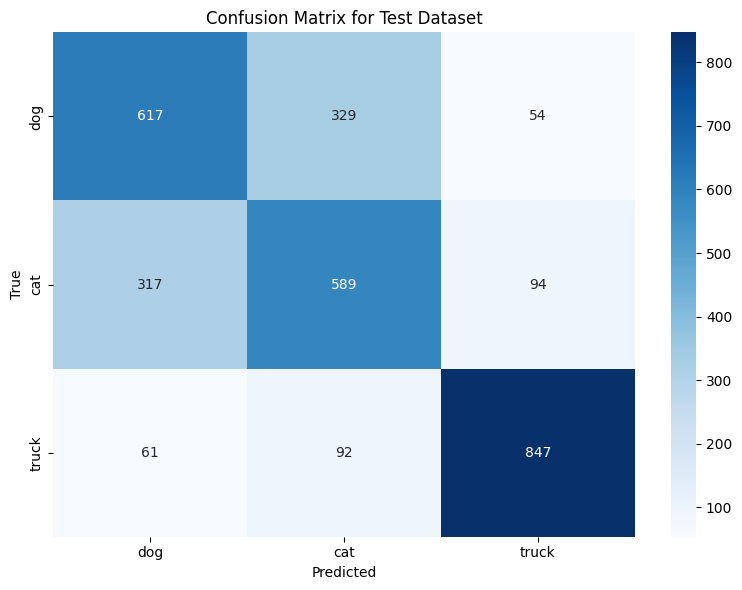


Detailed Classification Report:
              precision    recall  f1-score   support

         dog       0.62      0.62      0.62      1000
         cat       0.58      0.59      0.59      1000
       truck       0.85      0.85      0.85      1000

    accuracy                           0.68      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.68      0.68      0.68      3000



In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score

def test_model(model, test_loader, classes):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move model to device and set to evaluation mode
    model.to(device)
    model.eval()

    # Lists to store predictions and true labels
    all_preds = []
    all_labels = []

    # Disable gradient calculation during testing
    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in test_loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)

            # Update totals
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and labels for further analysis
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = 100 * correct / total

    # Calculate F1 Score
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Print test results
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Weighted F1 Score: {f1:.4f}')

    # Generate and plot confusion matrix
    def plot_confusion_matrix(labels, preds, title):
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes,
                    yticklabels=classes)
        plt.title(title)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, f'Confusion Matrix for Test Dataset')

    # Print detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': all_preds,
        'true_labels': all_labels
    }

test_results = test_model(model, test_loader, SELECTED_CLASSES)

#compare_models(cnn_model, mlp_model, test_loader, SELECTED_CLASSES)

In [ ]:
cnn_model = CIFAR10CNN(num_classes=3)
mlp_model = CIFAR10MLP(num_classes=3)

def compare_models(cnn_model, mlp_model, test_loader, classes):
    # Comparative Analysis
    plt.figure(figsize=(15, 5))

    # CNN Results
    print("CNN Model Results:")
    cnn_results = test_model(cnn_model, test_loader, classes)

    plt.subplot(1, 2, 1)
    plt.title('CNN Model Confusion Matrix')
    cm_cnn = confusion_matrix(cnn_results['true_labels'], cnn_results['predictions'])
    sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)

    # MLP Results
    print("\n" + "="*50 + "\n")
    print("MLP Model Results:")
    mlp_results = test_model(mlp_model, test_loader, classes)

    plt.subplot(1, 2, 2)
    plt.title('MLP Model Confusion Matrix')
    cm_mlp = confusion_matrix(mlp_results['true_labels'], mlp_results['predictions'])
    sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)

    plt.tight_layout()
    plt.show()

    # Comparative Summary
    print("\nModel Comparison Summary:")
    print(f"CNN Accuracy: {cnn_results['accuracy']:.2f}%")
    print(f"CNN F1 Score: {cnn_results['f1_score']:.4f}")
    print(f"MLP Accuracy: {mlp_results['accuracy']:.2f}%")
    print(f"MLP F1 Score: {mlp_results['f1_score']:.4f}")

    return cnn_results, mlp_results

compare_models(cnn_model, mlp_model, test_loader, SELECTED_CLASSES)

**loading saved dataset and testing on it**

<ipython-input-16-61071d6501f6>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load(model_path))


Test Accuracy: 78.67%
Weighted F1 Score: 0.7835


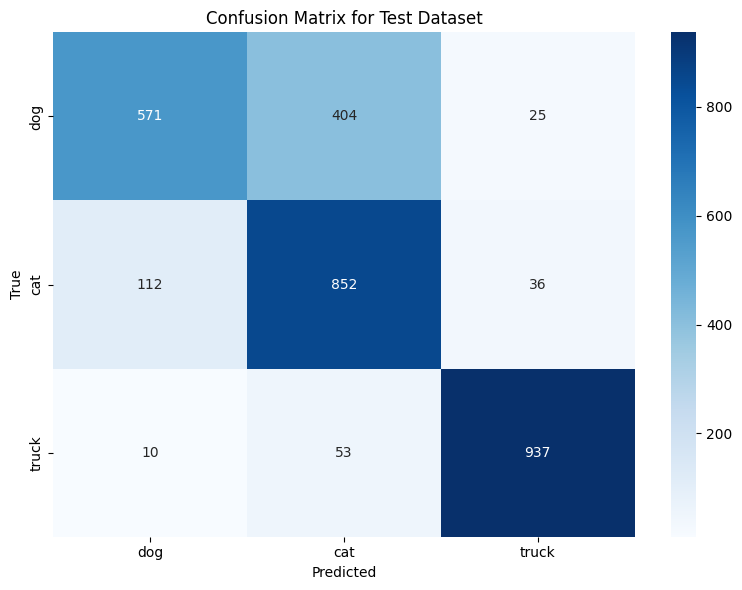


Detailed Classification Report:
              precision    recall  f1-score   support

         dog       0.82      0.57      0.67      1000
         cat       0.65      0.85      0.74      1000
       truck       0.94      0.94      0.94      1000

    accuracy                           0.79      3000
   macro avg       0.80      0.79      0.78      3000
weighted avg       0.80      0.79      0.78      3000



In [16]:
# Initialize the model with the same architecture
cnn_model = CIFAR10CNN(num_classes=3)

# Load the saved model weights
model_path = '/content/models/cifar10_cnn_model_final.pth'
cnn_model.load_state_dict(torch.load(model_path))

# If you want to evaluate it, you can now pass it to the test function
test_results = test_model(cnn_model, test_loader, SELECTED_CLASSES)


<ipython-input-18-bf58e397f1f8>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(model_path))


Test Accuracy: 68.43%
Weighted F1 Score: 0.6846


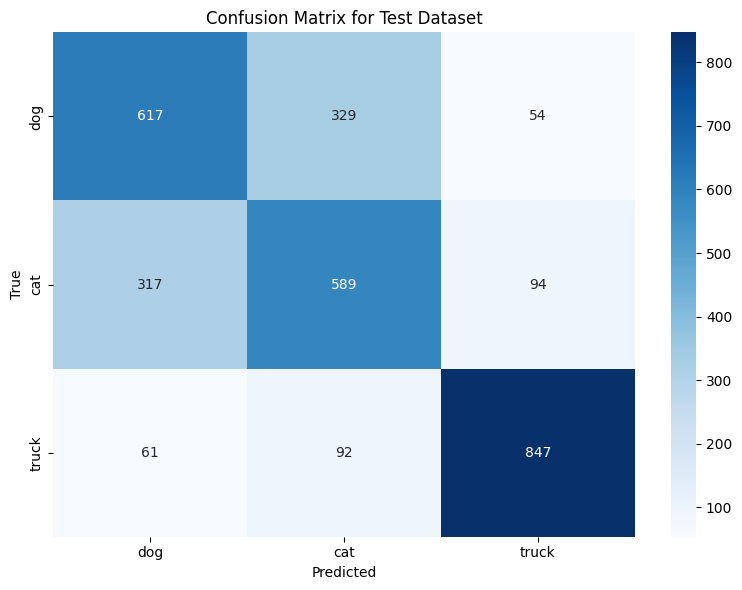


Detailed Classification Report:
              precision    recall  f1-score   support

         dog       0.62      0.62      0.62      1000
         cat       0.58      0.59      0.59      1000
       truck       0.85      0.85      0.85      1000

    accuracy                           0.68      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.68      0.68      0.68      3000



In [18]:
# Initialize the model with the same architecture
mlp_model = CIFAR10MLP(num_classes=3)

# Load the saved model weights
model_path = '/content/models/cifar10_mlp_model_final.pth'
mlp_model.load_state_dict(torch.load(model_path))

# If you want to evaluate it, you can now pass it to the test function
test_results = test_model(mlp_model, test_loader, SELECTED_CLASSES)
